<a href="https://colab.research.google.com/github/kumar-devesh/unet/blob/main/unetpytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

set dir_path as the path to the unet directory

In [ ]:
dir_path='/content/drive/Shareddrives/colab/unet/unet'

In [ ]:
!nvidia-smi

Fri May 21 20:06:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
batch_size=12

In [ ]:
#input dim=256*256, out= 11*256*256
def oneHotLabels(labels):
  labels = torch.from_numpy(labels)
  onehot=F.one_hot(labels.to(torch.int64),num_classes=11)
  return np.transpose(np.array(onehot),(2,0,1))

def intLabels(label):
  return np.argmax(label, axis=0)

In [ ]:
def plotLabel(label):
  plt.imshow(label)
  
def plotImage(image):
  image = np.array(image)
  plt.imshow(np.transpose(image,(1,2,0)))

# MODEL

##unet model (31M parameters)

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ConvBlock, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),

            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(negative_slope=0.05, inplace=True),
        )
    def forward(self, x):
      return self.conv(x)

class Down(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Down, self).__init__()
        self.conv = nn.Sequential(
            nn.MaxPool2d(kernel_size=2,stride=2),
            ConvBlock(in_channels, out_channels)
        )
        
    def forward(self, x):
        return self.conv(x)


class Up(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Up, self).__init__()
        self.up = nn.ConvTranspose2d(in_channels , out_channels, kernel_size=2, stride=2)
        self.conv = ConvBlock(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        x=self.conv(x)
        return x


In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels, n_classes,batch_size):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.n_classes = n_classes
        self.batch_size = batch_size

        self.inc = ConvBlock(in_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        self.down4 = Down(512, 1024)
        self.up1 = Up(1024, 512)
        self.up2 = Up(512, 256)
        self.up3 = Up(256, 128)
        self.up4 = Up(128, 64)
        self.outc = OutConv(64, n_classes)
        self.final = nn.Softmax(dim=1)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        out = self.outc(x)
        x = self.final(out[0:1])
        for i in range(1,self.batch_size,1):
          x=torch.cat([x,self.final(out[i:i+1])],dim=0)
        return x

In [ ]:
unet_model=UNet(in_channels=3, n_classes=11, batch_size=batch_size)

In [ ]:
total_params = sum(p.numel() for p in unet_model.parameters())
print(total_params)

31044171


In [ ]:
def test():
    x = torch.randn((1, 3, 256, 256))
    pred = unet_model(x)
    print(pred.shape)
test()

torch.Size([1, 11, 256, 256])


In [ ]:
if torch.cuda.is_available():
  device=torch.device('cuda')
else:
  device=torch.device('cpu')
unet_model.to(device)

run to load pretrained weights

In [ ]:
unet_model.load_state_dict(torch.load(os.path.join(dir_path,'model_weights.pth'), map_location=device))

<All keys matched successfully>

# DATASET

##helen dataset

In [ ]:
import os
import random
import cv2
import pandas as pd
import PIL
from PIL import Image
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import transforms

class HelenDataset(Dataset):
    def __init__(self, label_dir, img_dir):
        self.img_list=os.listdir(img_dir)
        self.label_list=os.listdir(label_dir)
        self.label_dir = label_dir
        self.img_dir = img_dir
        self.label_list.sort()
        self.img_list.sort()
        #print(self.label_list)
        #print(self.img_list)

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):

        img_path = os.path.join(self.img_dir, self.img_list[idx])
        image = Image.open(img_path)
        image = image.resize((256,256), resample=PIL.Image.BICUBIC)

        image = np.array(image)/255
        image = np.transpose(image,(2,0,1))
        image = torch.tensor(image, dtype=torch.float32, requires_grad=False)

        label_path = os.path.join(self.label_dir, self.label_list[idx])
        label = Image.open(label_path)
        label = label.resize((256,256), resample=PIL.Image.NEAREST)

        label = np.array(label)
        label = oneHotLabels(label)

        label = torch.tensor(label, dtype=torch.float32, requires_grad=False)

        sample = [image, label]
        return sample

In [ ]:
train_label_path= os.path.join(dir_path, "data/train/labels")
train_image_path= os.path.join(dir_path, "data/train/images")

training_data = HelenDataset(label_dir=train_label_path, img_dir=train_image_path)

test_label_path= os.path.join(dir_path, "data/test/labels")
test_image_path= os.path.join(dir_path, "data/test/images")

test_data = HelenDataset(label_dir=test_label_path, img_dir=test_image_path)

In [ ]:
from torch.utils.data import DataLoader
train_dataloader = DataLoader(training_data, batch_size, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size, shuffle=True)

In [ ]:
train_images, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_images.size()}")
print(f"Labels batch shape: {train_labels.size()}")

Feature batch shape: torch.Size([12, 3, 256, 256])
Labels batch shape: torch.Size([12, 11, 256, 256])


#MODEL TRAINING

##Tensorboard visualization

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter('runs/exp_1')

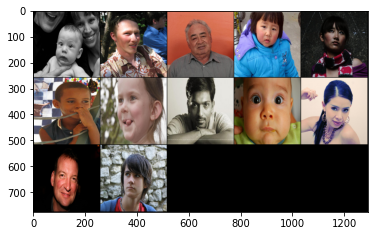

In [ ]:
images, labels = next(iter(train_dataloader))
img_grid = torchvision.utils.make_grid(images, nrow=4)
img_grig = np.array(img_grid)
img_grid = np.transpose(img_grid,(1,2,0))
plt.imshow(img_grid)

In [ ]:
images, labels = next(iter(train_dataloader))
img_grid = torchvision.utils.make_grid(images, nrow=5)
writer.add_image('images', img_grid)

add model graph

In [ ]:
writer.add_graph(unet_model, images.to(device))

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=runs

##Train model

In [ ]:
classes =['bg','face','lb','rb','le','re','nose','ulip','imouth','llip','hair']

In [ ]:
def twersky(y_pred, y_label):
    b=0.3
    #print(y_pred.size())
    x=y_pred*y_label
    intersection=torch.sum(x, dim=(2,3))
    union = b*torch.sum(y_label, dim=(2,3))+(1-b)*torch.sum(y_pred, dim=(2,3))
    loss = torch.sum(1-torch.div(intersection,union))
    print(loss.item())
    return loss

In [ ]:
def IOU(y_pred, y_label):
  x=y_pred*y_label
  intersection=torch.sum(x, dim=(2,3))
  union = torch.sum(y_label, dim=(2,3))+torch.sum(y_pred, dim=(2,3))+0.00001
  IOU_score = torch.sum(torch.div(intersection,union-intersection), dim=(0))
  return IOU_score

In [ ]:
optimizer = optim.Adam(unet_model.parameters(), lr=0.01, betas=(0.9, 0.999))
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.3, patience=5, min_lr=0.000001, eps=1e-08, verbose=True)

In [ ]:
def train(num_epochs, initial_loss, plot_gradients=False):
    start=0
    end=200*num_epochs
    running_loss = initial_loss
    for iteration in tqdm(range(start,end)):
        images, labels = next(iter(train_dataloader))
        images=images.to(device)
        labels=labels.to(device)
         
        preds = unet_model(images)
        loss = twersky(preds, labels)
      
        optimizer.zero_grad() #set gradients 0
        loss.backward() #calculate gradients

        nn.utils.clip_grad_norm_(unet_model.parameters(), max_norm=0.01, norm_type=2.0)
        optimizer.step() #update weights

        running_loss = running_loss*0.9 + loss.item()*0.1

        if plot_gradients and j%200==1:
          for tag, parm in unet_model.named_parameters():
            writer.add_histogram(tag, parm.grad.data.cpu().numpy(), iteration//200))

        if iteration % 50 == 1:
          scheduler.step(running_loss) #update lr
          writer.add_scalar('training loss', loss.item(), iteration)

          test_images, test_labels = next(iter(test_dataloader))
          test_images=test_images.to(device)
          test_labels=test_labels.to(device)

          unet_model.eval()
          preds = unet_model(test_images)
          iou = IOU(preds, test_labels)
          loss = twersky(preds, test_labels)
          writer.add_scalar('test loss', loss.item(), iteration)

          for i in range(11):
            writer.add_scalar('training iou class '+classes[i], iou[i], iteration)
          unet_model.train(True)
          torch.cuda.empty_cache()

        if iteration%1000==999:
          weights_path= os.path.join(dir_path, 'model_state'+str(iteration)+'.pth')
          torch.save(unet_model.state_dict(), weights_path)

        del images
        del labels

In [ ]:
train(num_epochs=40,initial_loss=batch_size*11)

In [ ]:
torch.cuda.empty_cache()

# PLOT RESULTS

run test set preds to save predictions on test set to ./data/test/preds (predictions already saved on model weights in preds dir)

##test set preds

In [ ]:
test_imgpath=os.path.join(dir_path,'data/test/images')
test_labelpath=os.path.join(dir_path,'data/test/labels')
test_predpath=os.path.join(dir_path,'data/test/preds')

In [ ]:
test_imglist=os.listdir(os.path.join(dir_path,'data/test/images'))
test_labellist=os.listdir(os.path.join(dir_path,'data/test/labels'))

In [ ]:
test_imglist.sort()
test_labellist.sort()

In [ ]:
for i in range(len(test_labellist)):
  img=Image.open(os.path.join(test_imgpath, test_imglist[i]))
  img=np.array(img)
  img=np.transpose(img,(2,0,1))
  img_tensor=torch.tensor(img,dtype=torch.float32)
  img_tensor=img_tensor.unsqueeze(0)

  label=Image.open(os.path.join(test_labelpath, test_labellist[i]))
  label=np.array(label)
  label_tensor=torch.tensor(label,dtype=torch.float32)
  label_tensor=label_tensor.unsqueeze(0)

  pred=unet_model(img_tensor.to(device))

  pred=np.array(pred.clone().detach().cpu())
  pred=intLabels(pred[0])
  pred=pred.astype(np.uint8)

  pred=Image.fromarray(pred)
  pred=pred.save(os.path.join(test_predpath, test_labellist[i]))

##plot results

`!python3   path/to/f1_score/    path/to/test/labels    path/to/test/preds  path/to/labels_names.txt`

In [ ]:
!python3 /content/drive/Shareddrives/colab/unet/unet/f1_score.py --help

usage: f1_score.py [-h] gt_dir pred_dir label_names_file

positional arguments:
  gt_dir            the directory containing the groundtruth labels (in .png)
  pred_dir          the directory containing the prediction labels (names
                    should be the same with groundtruth files)
  label_names_file  the path to label_names.txt file

optional arguments:
  -h, --help        show this help message and exit


In [ ]:
!python3 /content/drive/Shareddrives/colab/unet/unet/f1_score.py '/content/drive/Shareddrives/colab/unet/unet/data/test/labels' '/content/drive/Shareddrives/colab/unet/unet/data/test/preds' '/content/drive/Shareddrives/colab/unet/unet/label_names.txt'

100% 100/100 [00:00<00:00, 169.65it/s]
{'bg': ([0], [0]), 'face': ([1], [1]), 'lb': ([2], [2]), 'rb': ([3], [3]), 'le': ([4], [4]), 're': ([5], [5]), 'nose': ([6], [6]), 'ulip': ([7], [7]), 'imouth': ([8], [8]), 'llip': ([9], [9]), 'hair': ([10], [10]), 'eyes': ([4, 5], [4, 5]), 'brows': ([2, 3], [2, 3]), 'mouth': ([7, 8, 9], [7, 8, 9]), 'overall': ([4, 5, 2, 3, 6, 7, 8, 9], [4, 5, 2, 3, 6, 7, 8, 9])}
f1_bg=0.9379874802503227
f1_face=0.8975739275489326
f1_lb=0.7412928929443516
f1_rb=0.761212647106676
f1_le=0.8356334041047417
f1_re=0.8646787965487952
f1_nose=0.8890915506337703
f1_ulip=0.7408777201730343
f1_imouth=0.7816763526742705
f1_llip=0.8074722443257171
f1_hair=0.6783965714892594
f1_eyes=0.8500789292304956
f1_brows=0.7517517121254107
f1_mouth=0.8676697731729751
f1_overall=0.8555103672626286


In [ ]:
images, labels = next(iter(test_dataloader))
preds = unet_model(images.to(device))
x=torch.tensor(preds.clone().detach(),device='cpu')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
def label_grid(label):
  grid=intLabels(label[0])
  for i in range(1,3,1):
    grid=np.append(grid, intLabels(label[i]), axis=1)
  return grid

In [ ]:
preds=np.array(preds.clone().detach().cpu())
labels=np.array(labels.clone().detach().cpu())

In [ ]:
pred_grid=label_grid(preds)
label_grid=label_grid(labels)

In [ ]:
print(pred_grid.shape)

(256, 768)


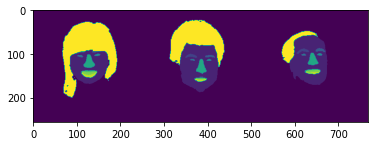

In [ ]:
%matplotlib inline
plt.imshow(pred_grid)

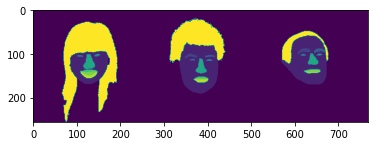

In [ ]:
plt.imshow(label_grid)